<div class="alert alert-block alert-success">
<b>Objectives:</b> In this notebook we fit a machine learning model to quantify dependencies of predicted pollutant concentrations on weather conditions, or any other factors we have access to for that matter. As with the previous notebook, we build our excises around a set of key objectives that are listed below.
        
 - 1) [Fitting machine learning models of pollutant concentrations: time-series](#Part1)
      * [Exercise 1: Fit a machine learning model to predict PM2.5 as a function of time and meterology.](#Exercise1)
 - 2) [Interpreting machine learning models of pollutant concentrations](#Part2)
      * [Exercise 2: Generate partial dependency plots to understand relationships between PM2.5 predictions and meteorology.](#Exercise2)
      * [Exercise 3: Generate SHAP analysis for predicting PM2.5 at Manchester Piccadilly site](#Exercise3)
 - 3) [Automated machine learning models of pollutant concentrations](#Part3)
      * [Exercise 4: Assess sensitivity of derived changepoints from sliding window analysis.](#Exercise4)
 
As with our other notebooks, we will provide you with a template for plotting the results. Also please note that you should not feel pressured to complete every exercise in class. These practicals are designed for you to take outside of class and continue working on them. Proposed solutions to all exercises can be found in the 'Solutions' folder.
</div>

In [1]:
if 'google.colab' in str(get_ipython()):
    
    # Mount the Google Drive at mount
    from google.colab import drive
    mount='/content/gdrive'
    print("Colab: mounting Google drive on ", mount)

    drive.mount(mount)

    # Switch to the directory on the Google Drive that you want to use
    import os
    from os import path
    
    drive_root = mount + "/My Drive/Colab Notebooks/MPEC_bootcamp/Time-series-analytics-course"
    # Change to the directories to get data files
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root
        
    !pip install shap
    !pip install ruptures
else:
    print("not working in Google Colab!")

not working in Google Colab!


In [2]:
import pdb
import pandas as pd
import numpy as np
import datetime
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import os
from xgboost.sklearn import XGBRegressor
import datetime as dt
import pickle
import xgboost
from sklearn.inspection import partial_dependence, permutation_importance
import shap
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import os
import glob
path=os.getcwd()
%matplotlib inline

# 1) Fitting machine learning models of pollutant concentrations: time-series 

Time series forecasting reflects the process of attempting to use present and/or historical time series data to predict what may happen in the future. That could vary from 1 hour to a few days. Take the figure below. Here we illustrate the principal here using an array of values captured over a set interval, where one array stores the values of say, $NO_{2}$, and the other an array to store time. We find that time, whilst valuable, is not something we can solely rely on. We also need meterological data, which you can imagine contained with another set of parallel arrays.

<img src="images/Prophet_schematic1.jpg" alt="Time series forecasting techniques" style="width: 600px;"/>

There is an entire area of research in this field, from statistical to machine learning approaches. Which method is the most appropriate depends on what you are trying to predict and the properties of your data. We cover some of these in previous notebooks including understanding whether our data is stationary or not. 

<img src="images/prophet.png" alt="Time series forecasting techniques" style="width: 600px;"/>

The figure above is taken from the documentation of the [Neural Prophet method](https://neuralprophet.com/). It serves mainly to illustrate two separate families of methods and reference to some names you may or may not come across. In this module we are going to use very popular approahces to fit a machine learning model to time varying data. Whilst the accuracy of those methods for forecasting ahead of time are important, our principal aim in this course is to make sure they can reflect the time varying nature of our data and then use them to interogate the relationships the model has discovered in the process. What do I mean by this? The figure below provides one of the end goals of the coding provided in this notebook. 

Given this is potentially your first time fitting a machine learning model, there are some important steps to become familar with. Up to this point we have focused entirely on data exploration, or EDA as noted previously. Now we need to fit a model. Whilst we make reference to time series forecasting, we are taking a general approach and not evlaluating a models ability to predict ahead of time. Rather, we are fitting a model to time series data and the  interrogating that model to understand relationships in our data. For more information, and activity, on time series forecasting specifically, there are multiple resources you can take a look at [add later].

<div style="border-left: 5px solid #1f77b4; background-color: #f0f8ff; padding: 10px; margin: 10px 0;">
    <strong>💡 Please note:</strong> There is a lot here, and you will find more details on each step as we go through them in turn. The important thing to know for now is that, these steps — feature engineering, splitting, training, evaluating, and tuning — form the foundation of any machine learning workflow. In this course, we’ll apply these concepts to time-aware structured data to predict air pollutant concentrations.
</div>

------------------------


## 1.1) General Principles of Fitting Machine Learning Models

In this course, we will focus on **fitting machine learning models** to time series-related data — not forecasting future values, but using time-based variables (like hour, day, month) to explain variation in a target variable (e.g. air pollutant concentrations). Below are the core steps involved in any machine learning workflow.

### 1. Understand the Problem and the Data

Before fitting a model, clearly define the **objective**: What are you trying to predict? What data is available to help you do this? Understand the **target variable** (the thing you're predicting) and the **features** (the variables you’ll use as input).

### 2. Feature Engineering

This step involves transforming raw data into features that better expose the underlying structure of the problem to the model.

- **Time-based features** are especially useful in time series contexts. From a datetime column, you can extract:
  - Hour of day
  - Day of week
  - Month or season
  - Whether it's a weekend or holiday

- You might also consider **lag features** (past values of variables -  see previous notebook!), though in this course we won’t do temporal forecasting.

- All features should be numeric or encoded (e.g., one-hot encoding for categorical variables).

We have already been performing steps **1**-**2** in the code presented below:

First we will load hourly pollutant data from the Manchester sites of the Automatic Urban and Rural Network (AURN). We have downloaded this data for you. From the imported data, we can understand the basic information of each site, such as monitoring time, types of pollutants, site name, site type, site location, etc. Each site is also automatically matched with meteorological data from both the monitoring network itself and the ECMWF ERA5 re-analysis. ERA5 is the fifth-generation global climate and weather reanalysis produced by the European Centre for Medium-Range Weather Forecasts (ECMWF). It uses advanced modeling and data assimilation techniques to merge historical observations—from satellites, ground stations, weather balloons, and more—into a consistent, high-resolution dataset of atmospheric, land surface, and sea-state variables. Covering data as far back as 1979 (with ongoing updates), ERA5 provides hourly estimates of essential climate variables such as temperature, wind, and precipitation. This comprehensive and spatially detailed dataset is widely used for climate monitoring, research, and applications in hydrology, agriculture, renewable energy, and other fields requiring accurate historical weather and climate information.

    *The meteorological parameters from sites are: wind speed (ws, m/s), wind direction (wd, °), temperature (temp, ℃).
    
    *The meteorological parameters from ERA5 re-analysis dataset are: 10m u-component of wind (u10, m/s), 10m v-component of wind (v10, m/s), 2m temperature (t2m, ℃), boundary layer height (blh, m), surface pressure (sp, hPa), surface solar radiation downwards (ssrd, J/m2), total rainfall (tp, m), relative humidity (r, %).


In [13]:
# The 'glob' module searches for all files that meet the specified criteria
station_files=glob.glob('./data/AutoML/*.csv')
# we decide to simply load the 3rd file in the list of available files
example_station=pd.read_csv(station_files[2])
# preview to the screen
example_station

,date,O3,NO,NO2,NOXasNO2,SO2,CO,PM10,site,code,...,Ox,u10,v10,d2m,t2m,blh,sp,ssrd,tp,r
0,25/11/2010 00:00,28.00000,5.00000,36.00000,44.00000,NaN,NaN,NaN,Manchester Piccadilly,MAN3,...,31.737663,1.152269,-2.325125,270.189941,271.543427,313.178223,99113.98438,0.000,-4.660000e-10,83.760262
1,25/11/2010 02:00,42.00000,3.00000,23.00000,27.00000,NaN,NaN,NaN,Manchester Piccadilly,MAN3,...,31.948125,1.051118,-2.578859,269.913361,271.170105,369.558472,99079.18750,0.000,-4.660000e-10,81.644234
2,25/11/2010 03:00,46.00000,3.00000,21.00000,25.00000,NaN,NaN,NaN,Manchester Piccadilly,MAN3,...,32.874158,1.120659,-2.446536,269.555878,270.866363,363.322510,99062.98438,0.000,-4.660000e-10,81.059067
3,25/11/2010 04:00,46.00000,3.00000,23.00000,27.00000,NaN,NaN,NaN,Manchester Piccadilly,MAN3,...,33.884375,1.234453,-2.144374,269.149322,270.481171,359.264770,99053.21875,0.000,-4.660000e-10,80.167725
4,25/11/2010 05:00,44.00000,3.00000,25.00000,29.00000,NaN,NaN,NaN,Manchester Piccadilly,MAN3,...,33.926467,1.453191,-1.872223,268.833893,270.126801,330.519409,99054.88281,0.000,-4.660000e-10,80.222076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99371,05/11/2023 19:00,7.14197,15.15972,51.58684,74.83143,1.15989,NaN,41.700,Manchester Piccadilly,MAN3,...,29.514121,1.882244,1.775450,279.260590,280.760864,231.899780,97078.70313,0.125,4.910000e-05,90.358765
99372,05/11/2023 20:00,7.19733,12.37396,45.26753,64.24067,0.96658,NaN,46.950,Manchester Piccadilly,MAN3,...,26.348981,1.404501,2.025538,279.316894,280.508942,189.056885,97133.26563,0.125,1.349760e-04,91.411278
99373,05/11/2023 21:00,9.30117,9.16710,42.47776,56.53378,0.83770,NaN,35.700,Manchester Piccadilly,MAN3,...,25.958234,1.031469,2.418028,278.974487,280.085693,179.768921,97167.72656,0.125,2.060000e-05,92.087143
99374,05/11/2023 22:00,13.89639,6.54330,37.00398,47.03690,0.77326,NaN,22.025,Manchester Piccadilly,MAN3,...,25.417753,0.169242,2.350724,278.566101,279.483948,137.654541,97201.53125,0.125,1.430000e-05,90.295990


In [14]:
# load the site files and select the pollutant concentration and meteorological parameters. Here we use MAN3 as an example
MAN3_DATA=pd.read_csv(station_files[2])
print(MAN3_DATA.columns)

Index(['date', 'O3', 'NO', 'NO2', 'NOXasNO2', 'SO2', 'CO', 'PM10', 'site',
       'code', 'latitude', 'longitude', 'location_type', 'NV10', 'V10',
       'PM2.5', 'NV2.5', 'V2.5', 'wd', 'ws', 'temp', 'AT2.5', 'AP2.5', 'Ox',
       'u10', 'v10', 'd2m', 't2m', 'blh', 'sp', 'ssrd', 'tp', 'r'],
      dtype='object')


We convert a number of metrics that exist in this file to variables that are better suited to time-series problems. We also extract time components such as hour of day, day of the week, month of the year and 'unix time'. Please see the lecture and associated notes to understand why we do this in this instance. 

In [15]:
# Convert wind direction to a continuous variable
MAN3_DATA['U']=np.cos(np.radians(MAN3_DATA['wd']))*MAN3_DATA['ws']
MAN3_DATA['V']=np.sin(np.radians(MAN3_DATA['wd']))*MAN3_DATA['ws']
# Convert string date to datetime format
MAN3_DATA['datetime'] = pd.to_datetime(MAN3_DATA['date'])
# sort the values according to time of measurement
MAN3_DATA=MAN3_DATA.sort_values(by='datetime',ascending=True)
# set the index to the datetime
MAN3_DATA=MAN3_DATA.set_index('datetime')

# Re-record time metrics in the new data frame
MAN3_DATA['hour']=MAN3_DATA.index.hour
MAN3_DATA['day']=MAN3_DATA.index.weekday
MAN3_DATA['month']=MAN3_DATA.index.month
MAN3_DATA['unix']=(MAN3_DATA.index - dt.datetime(1970,1,1)).total_seconds()
MAN3_DATA['day_of_year']=MAN3_DATA.index.day_of_year

C:\Users\davet\AppData\Local\Temp\ipykernel_27064\2725934684.py:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  MAN3_DATA['datetime'] = pd.to_datetime(MAN3_DATA['date'])


In [16]:
print(MAN3_DATA.columns)

Index(['date', 'O3', 'NO', 'NO2', 'NOXasNO2', 'SO2', 'CO', 'PM10', 'site',
       'code', 'latitude', 'longitude', 'location_type', 'NV10', 'V10',
       'PM2.5', 'NV2.5', 'V2.5', 'wd', 'ws', 'temp', 'AT2.5', 'AP2.5', 'Ox',
       'u10', 'v10', 'd2m', 't2m', 'blh', 'sp', 'ssrd', 'tp', 'r', 'U', 'V',
       'hour', 'day', 'month', 'unix', 'day_of_year'],
      dtype='object')


### 3. Split the Data: Train, Validation, and Test Sets (Random Split)

It’s essential to **separate training and testing data** to evaluate how well your model generalizes to unseen data.

- In time series problems, you usually avoid random shuffling.
- Instead, use **time-aware splits**, such as:
  - Train on earlier data and test on later data
  - Alternatively, use methods like **TimeSeriesSplit** from scikit-learn
- We will use a simple random shuffling for now.

The code is presented below before a description is given: **please note how I am using only a subset of data for the purposes of accelerating our training example. You might want to change this, as we will in the section using AutoML, to look at the entire dataset.**

In [17]:
# prepare the training and test dataset for building the machine learning model
from sklearn.model_selection import train_test_split

sample_df=MAN3_DATA[MAN3_DATA.index.year==2018]

y=sample_df[['PM2.5']].values
X=sample_df[['wd', 'ws', 'temp', 'AT2.5', 'AP2.5', 'u10', 'v10', 'd2m', 't2m', 'blh', 'sp', 'ssrd', 'tp', 'r', 'U', 'V','hour', 'day', 'month', 'unix', 'day_of_year']].values

# First split: 85% train+val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=10
)

# Second split: from the 85%, split 80% train, 20% val → gives 68% train, 17% val
X_train, X_validate, y_train, y_validate = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=10
)

In this project, we aim to fit a machine learning model to estimate the influence of weather on pollutant values. Because we're **not doing time series forecasting**, we can use a **random split** of the data without worrying about the order of time.

#### Why Split the Data?

We divide the data into three parts to fairly evaluate model performance and avoid overfitting:

#### a). Training Set (~68% of data)
This is used to fit the model — it "learns" the relationship between input features (like weather and time variables) and the target (NO₂ concentration).

#### b). Validation Set (~17% of data)
Used during model development to tune parameters and compare different models. It helps evaluate how well the model generalises to unseen data.

#### c). Test Set (~15% of data)
This set is kept completely separate and is used only once at the end to evaluate final model performance. It gives an unbiased estimate of real-world model behaviour.

#### Random Splitting

Since we are not forecasting into the future, it's acceptable — and often useful — to randomly shuffle the data before splitting. This helps ensure that all subsets contain a representative mix of different weather and pollution conditions.


### 4. Choose a Model

For structured data, **tree-based models** like XGBoost, LightGBM, or Random Forests are excellent starting points.

These models:
- Handle non-linear relationships
- Don’t require feature scaling
- Are robust to missing values and irrelevant features
- Perhaps more importantly...we can interrogate them to extract the underlying relationships within our data!!

#### Introduction to XGBoost (eXtreme Gradient Boosting)

In this course, we’ll be using a machine learning model called **XGBoost** to help us understand how different variables (like weather conditions and time of day) influence pollutant concentrations — such as NO₂. Even if you’ve never worked with machine learning models before, that’s okay! This section will introduce XGBoost in simple terms.

<div>
<img src="images/XGBoost_explainer.png" width="600"/>
</div>

It's known for its speed, efficiency, and ability to scale well with large datasets. In addition, XGBoost (Extreme Gradient Boosting) offers a range of hyperparameters that control model complexity, regularization, and boosting behavior. Commonly tuned parameter:
 - include n_estimators (the number of boosting rounds)
 - learning_rate (sometimes called eta, controlling the contribution of each tree)
 - max_depth (the depth of each tree)
 - subsample (the fraction of training samples used per tree)
 - colsample_bytree (the fraction of features used per tree)
 - gamma (minimum loss reduction required to make a further partition)
 - min_child_weight (minimum sum of instance weights needed in a child), and reg_alpha / reg_lambda (L1/L2 regularization terms). 
 
Tuning these hyperparameters can significantly improve model performance and prevent overfitting. One straightforward approach is to use a random search over a predefined parameter grid, which tries a set number of random combinations and often finds good solutions quickly without exhaustive searches.
Below is an example of using a random search to tune an XGBRegressor with scikit-learn’s RandomizedSearchCV. Please note that Cross-validation is a technique used to evaluate a model’s performance by partitioning the data into multiple “folds” or subsets, training the model on some folds, and then testing it on the remaining fold(s). This process is repeated several times, with each fold serving as the test set once. The results (e.g., accuracy, RMSE, R²) are averaged across all runs to obtain a more reliable estimate of the model’s performance. By using multiple folds as distinct test sets, cross-validation reduces the risk of overfitting to a single train-test split and provides a more robust measure of how well the model generalizes to unseen data.


#### 👣 Summary

- XGBoost is a **boosted tree** model that builds many small decision trees and combines them into a strong overall model.
- It’s fast, accurate, and well-suited to the type of tabular data we’re working with.
- The model has many **settings** (hyperparameters), but you don’t need to understand all of them to start.
- We'll begin with sensible defaults and learn how to tune these parameters later using **validation** and **cross-validation**.

In the next steps, we’ll fit an XGBoost model to our weather and time features to help explain pollutant levels in a more robust, data-driven way.


### 5. Train the Model

Fit the model on the training data. This is where the algorithm learns patterns from the input features that relate to the target variable.

- In XGBoost, this usually involves specifying parameters like `max_depth`, `learning_rate`, and `n_estimators` as described above. 
- You can start with default settings and then we will try to improve them via tuning.

This code demonstrates how to perform hyperparameter tuning for an XGBoost regression model using `RandomizedSearchCV` from Scikit-learn. First, a dictionary of possible hyperparameter values is defined, including values for the number of trees, learning rate, tree depth, and various regularization and sampling parameters. These influence how the model learns patterns from data. In other words, hyperparameters are the **settings or knobs** you configure before training a model. Unlike model parameters (which the model learns from data, like weights in linear regression), hyperparameters **control the learning process itself**.

Examples of hyperparameters in common models:

- **XGBoost:**
  - `max_depth`: how deep each tree can grow (controls model complexity)
  - `learning_rate`: how much the model adjusts in each round of training
  - `n_estimators`: number of boosting rounds (trees)
- **Random Forest:**
  - `n_estimators`: number of trees in the forest
  - `max_features`: number of features considered at each split

Default settings may work okay, but they’re not optimized for your specific dataset. Good tuning can significantly improve performance and reduce overfitting or underfitting. There are two common approaches to finding the optimum parameters:

- **Grid Search**: Try all combinations of specified hyperparameter values.
- **Random Search**: Randomly sample combinations from a defined range — faster for large search spaces.

Next, an `XGBRegressor` is created, which is a popular model for regression tasks that uses gradient boosting. To find the best combination of parameters, a `RandomizedSearchCV` is set up. This method tries a limited number of random combinations (10 in this case) from the provided options, using **cross-validation** to assess performance. 

**Cross-validation** is a technique used to evaluate how well a machine learning model is likely to perform on unseen data. In this case, 3-fold cross-validation is used, which means the training data is split into three parts: the model is trained on two parts and validated on the third, rotating through all combinations. This helps ensure that the evaluation is not biased by the way the data is split, and it gives a more reliable estimate of model performance.

After training the model with the training data, the best parameters found are printed. Finally, the model is evaluated on the test data using the R² score, which tells us how well the model predicts compared to the actual results.



In [18]:
# Define the parameter distributions to sample from
param_distributions = {
    'n_estimators':      [100, 200, 300, 400],
    'learning_rate':     [0.01, 0.05, 0.1],
    'max_depth':         [3, 5, 7, 9],
    'subsample':         [0.6, 0.8, 1.0],
    'colsample_bytree':  [0.6, 0.8, 1.0],
    'gamma':             [0, 0.1, 1, 5],
    'min_child_weight':  [1, 3, 5],
    'reg_alpha':         [0, 0.01, 0.1, 1],
    'reg_lambda':        [0.1, 1, 2, 5]
}

# Create the XGBoost regressor
xgb_reg = XGBRegressor(random_state=42)

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_distributions,
    n_iter=10,            # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error',  
    cv=3,                 # 3-fold cross validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the random search model
random_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found:", random_search.best_params_)

# Evaluate on test set
best_model = random_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test R^2:", test_score)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}
Test R^2: 0.6995891136952486


Congratulations, you have just fit a ML model to predict pollutant concentrations!!

Now lets produce a few plots comparing the original and predicted dataset, using code we have already used in previous notebooks. This shows us how we can access the `best_model` estimator.  Lets first create a new column in our sub_sample data frame and then populate the predictions in that datafrane using this new model.

In [21]:
# Use the same features that were used in training
# Predict using the best model
y_pred = best_model.predict(X)

# Create a new column in the dataframe
sample_df['PM2.5_predicted']=y_pred

C:\Users\davet\AppData\Local\Temp\ipykernel_27064\2849755104.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['PM2.5_predicted']=y_pred


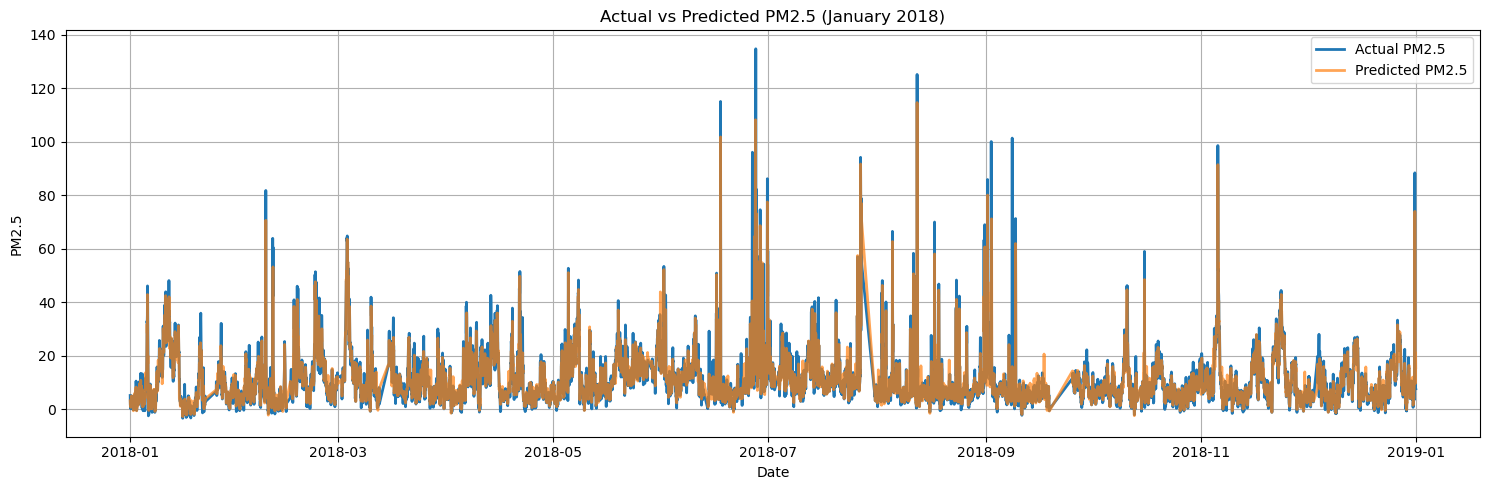

In [28]:
# Generate a basic line plot to show how the two compare over time
plt.figure(figsize=(15, 5))
plt.plot(sample_df.index, sample_df['PM2.5'].dropna(), label='Actual PM2.5', linewidth=2)
plt.plot(sample_df.index, sample_df['PM2.5_predicted'].dropna(), label='Predicted PM2.5', linewidth=2, alpha=0.7)
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.title('Actual vs Predicted PM2.5 (January 2018)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

You may have noticed I use '.dropna()'; this is to remove any NaNs from our dataframe so it remains on the same plot. A useful comparison between actual and predicted values should include both error metrics and summary statistics. These give you a sense of how accurate your model is and where it might be biased.

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Drop any rows with missing predictions
comparison_df = sample_df[['PM2.5', 'PM2.5_predicted']].dropna()

# Extract actual and predicted values
y_true = comparison_df['PM2.5'].values
y_pred = comparison_df['PM2.5_predicted'].values

# Calculate statistics
results = {
    'Mean': [y_true.mean(), y_pred.mean()],
    'Std Dev': [y_true.std(), y_pred.std()],
    'Min': [y_true.min(), y_pred.min()],
    'Max': [y_true.max(), y_pred.max()],
    'MAE': ['-',mean_absolute_error(y_true, y_pred)],
    'MSE': ['-',mean_squared_error(y_true, y_pred)],
    'R² Score': ['-',r2_score(y_true, y_pred)]
}

# Format into DataFrame
metrics_df = pd.DataFrame(results, index=['Actual', 'Predicted'])

# Fill NAs for predicted-only rows
metrics_df = metrics_df.round(3)
metrics_df

,Mean,Std Dev,Min,Max,MAE,MSE,R² Score
Actual,10.892,10.019,-3.400,134.800,-,-,-
Predicted,10.823,8.928,-2.779,114.662,1.65593,12.427814,0.876186


So we have some initial stats. Do you see any problems with the above? The performance looks 'ok' although what are we comparing with? Notice we have some negative numbers here aswell, which means we should be cleaning the data. For now we can also produce some diurnal comparisons:

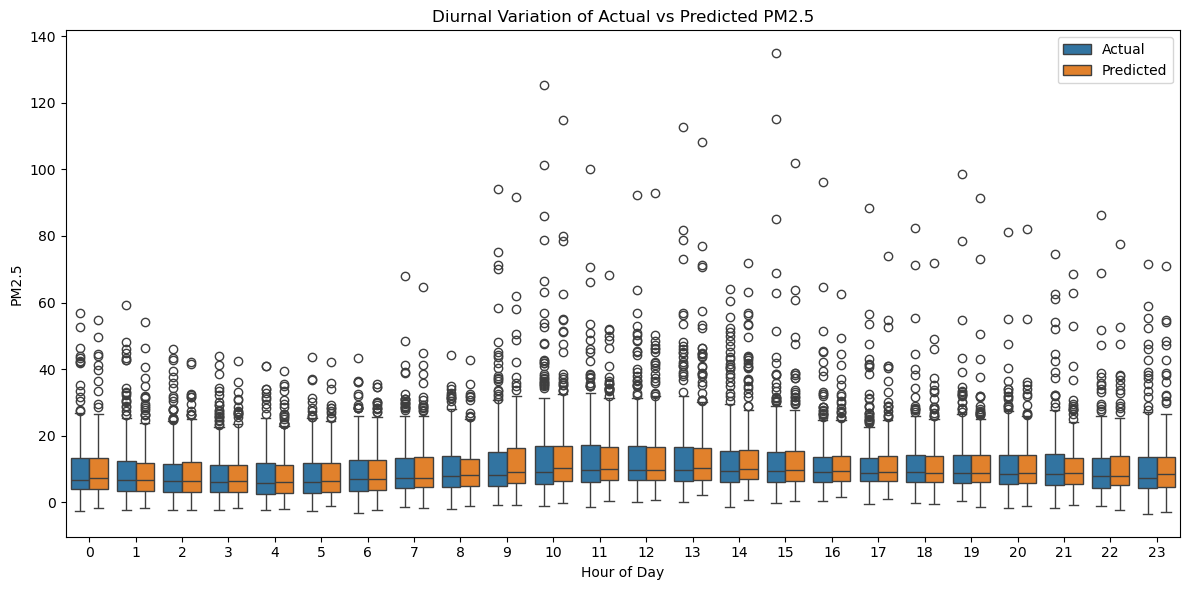

In [43]:
import seaborn as sns
import pandas as pd

# Drop rows with missing values
df_melted = sample_df[['hour', 'PM2.5', 'PM2.5_predicted']].dropna().melt(
    id_vars='hour',
    var_name='Type',
    value_name='Value'
)

# Optional: clean up labels
df_melted['Type'] = df_melted['Type'].replace({
    'PM2.5': 'Actual',
    'PM2.5_predicted': 'Predicted'
})

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='Value', hue='Type', data=df_melted)
plt.title('Diurnal Variation of Actual vs Predicted PM2.5')
plt.xlabel('Hour of Day')
plt.ylabel('PM2.5')
plt.legend(title='')
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
<b> Exercise 1 - Fit a machine learning model to predict NOx as a function of time and meterology<a name="Exercise1"></a></b> 
    
Repeat the above workflow to compare ML models fit to our data but matching the following criteria:
    
    - The predictor variable changes to NOx
    - Only include data from 2017 and 2018.
    - Use 15 parameter settings that are sampled from the randomised hyperparameter search
    
Then produce:
 -  A table summary of statistics
 -  A time series line plot comparing actual and measured NOx
 -  A diurnal comparison between actual and measured NOx

</div>

# 2) Interpreting machine learning models of pollutant concentrations

## 🔍 Model Interpretation: Partial Dependence Plots and SHAP Values

As machine learning models become more complex (like XGBoost or random forests), it becomes harder to understand **how** they are making predictions. Fortunately, there are powerful tools to help us **interpret** these models. 

---

<div style="border-left: 5px solid #1f77b4; background-color: #f0f8ff; padding: 10px; margin: 10px 0;">
    <strong>💡 Please note:</strong> We implement both of the following in the code that follows, with more detail provided, but for an overview:
</div>

#### Partial Dependence Plots (PDPs)

**What it is**:  
Partial Dependence Plots show the **average effect** of a single feature (or a pair of features) on the model’s prediction.  
They help answer the question:  
> *"On average, how does changing this feature affect the model output?"*

**Key characteristics**:
- Plots model predictions while varying one feature, keeping others fixed.
- Good for understanding **general trends** (e.g., does higher temperature increase PM2.5?).
- Works best for **continuous or ordinal features**.

**Useful for**:
- Feature influence in a global, average sense.
- Spotting linear/non-linear relationships.

---

#### SHAP (SHapley Additive exPlanations)

**What it is**:  
SHAP values provide a **game-theoretic** approach to explain individual predictions.  
They tell us:
> *"How much did each feature contribute to this specific prediction?"*

**Key characteristics**:
- Based on Shapley values from cooperative game theory.
- Works with any model, including tree-based ones like XGBoost.
- Can explain **individual predictions** (local interpretation) or show overall trends (global interpretation).

**SHAP visualizations** can show:
- How important each feature is overall.
- For one prediction: which features pushed the value up or down.
- Feature effects across the whole dataset (summary plots).

**Useful for**:
- Debugging models.
- Identifying bias.
- Explaining results to non-technical audiences.

---

#### Summary

| Tool | Focus | Insight Type | Best For |
|------|-------|--------------|----------|
| **PDP**  | One feature at a time | Global trend | Feature influence (average effect) |
| **SHAP** | All features together | Local & global | Feature contribution to predictions |

These tools are especially important when using **black-box models**, and help bridge the gap between **accuracy** and **interpretability**.


#### 2.1 Partial dependencies

Now we have a pre-trained model and we have created our X and Y variables, there is an important feature of tree based methods we can use to our advantage. With any machine learning model we want to avoid creating a 'black box' which makes predictions based on inferred relationships we cant interrogate. We can refer to the Scikit-learn documentation to understand this a little:

*Partial dependence plots (PDP) show the dependence between the target response and a set of input features of interest, marginalizing over the values of all other input features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest.*

There are a number of terms here. Marginalisation is a method that requires summing over the possible values of one variable to determine the marginal contribution of another. So, in other words, if we want to try and untangle the relationship between PM2.5 and temperature, we need to make sure we account for all combinations of the other variables in this process. This can be problematic. As we see from the Scikit-learn documentation, in this process we assume that the input features of interest are independent from the complementary features, and this assumption is often violated in practice. Nonetheless, we can extract useful insights from our model and thus data in the process. 

For those interested in the general algorithm, this is given as follows:

Here's a step-by-step process to calculate partial dependencies from a trained machine learning model:

 - 1. Choose the feature: Select the feature for which you want to calculate the partial dependency. This is the feature you will vary while keeping the values of all other features fixed.
 - 2. Create a grid of feature values: Define a set of values for the selected feature, covering its range or distribution in the dataset. This grid will be used to calculate the model's predictions for each value while holding other features constant.
 - 3. Fix the values of other features: For each instance in your dataset or a representative sample, fix the values of all features except the one you're interested in. You can use the mean, median, or any other reference value for the other features.
 - 4. Calculate predictions: For each fixed instance, replace the selected feature's value with each value from the grid you created in step 2. Then, calculate the model's prediction for each instance-feature value combination.
 - 5. Average predictions: For each value in the grid, average the predictions across all instances. This will give you the partial dependency of the model's prediction on the selected feature value.


Keep in mind that PDPs may not always accurately capture complex interactions or non-linear relationships, especially for high-dimensional models or those with strong interactions between features. In such cases, more advanced techniques like SHAP values might be more suitable for interpreting the model.

We have generated our trained model and we will also import a function called <code> partial_dependence </code> from the Scikit-learn package. This function takes a pre-trained model, the original data and 'X' variables, and a variable of interest. In this case, as defined below, we want to plot the partial dependence of our predicted 'PM2.5' on variable 'temp', thus temperature. Run the code below. You may find it can take a minute or so to complete. The reason for this is that it is calculating the partial dependency by performing the marginalisation described above.

In [44]:
pardep = partial_dependence(best_model, sample_df[['wd', 'ws', 'temp', 'AT2.5', 'AP2.5', 'u10', 'v10', 'd2m', 't2m', 'blh', 'sp', 'ssrd', 'tp', 'r', 'U', 'V','hour', 'day', 'month', 'unix', 'day_of_year']], ['temp'])

What has just happened? The output <code> pardep </code> is a dictionary of results. In the following code we plot the range of <code> temp </code> values used during the calculation and the average impact on <code> PM2.5 </code>.

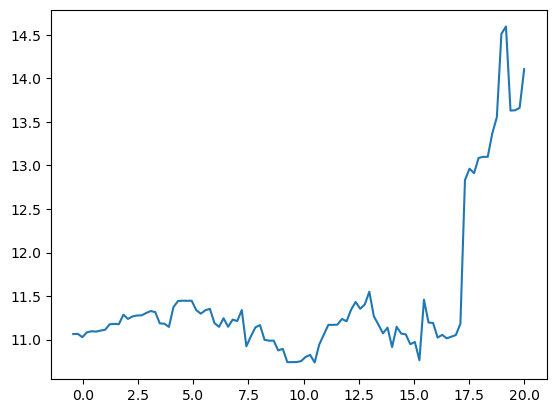

In [45]:
plt.plot(pardep['grid_values'][0],pardep['average'][0])
plt.show()

This code is generating a **Partial Dependence Plot (PDP)** for the feature `'temp'` (temperature). PDPs help us understand how a single input feature affects the model’s predictions, while keeping all other features constant.

- It uses the `partial_dependence()` function to calculate how the model's prediction changes across a range of temperature values.
- Then it plots this relationship using `matplotlib`.
- `pardep['grid_values'][0]` gives the range of temperature values over which the PDP was calculated — e.g., 0°C to 35°C.

The result is a line plot showing how temperature, on average, influences the model’s output — making the model's behavior more interpretable. This is an interesting plot. Based on the range of temperature values captured in our data, we see there is a regime of increased levels of predicted PM2.5. Because we have trained our model to 1 year of data, we cant say for sure how representative this is of the site. How would you improve this?
In the following code we produce another PDP plot but also combine this with a histogram of the temperature values, so we can visualise the frequency of occurance across our dataset.

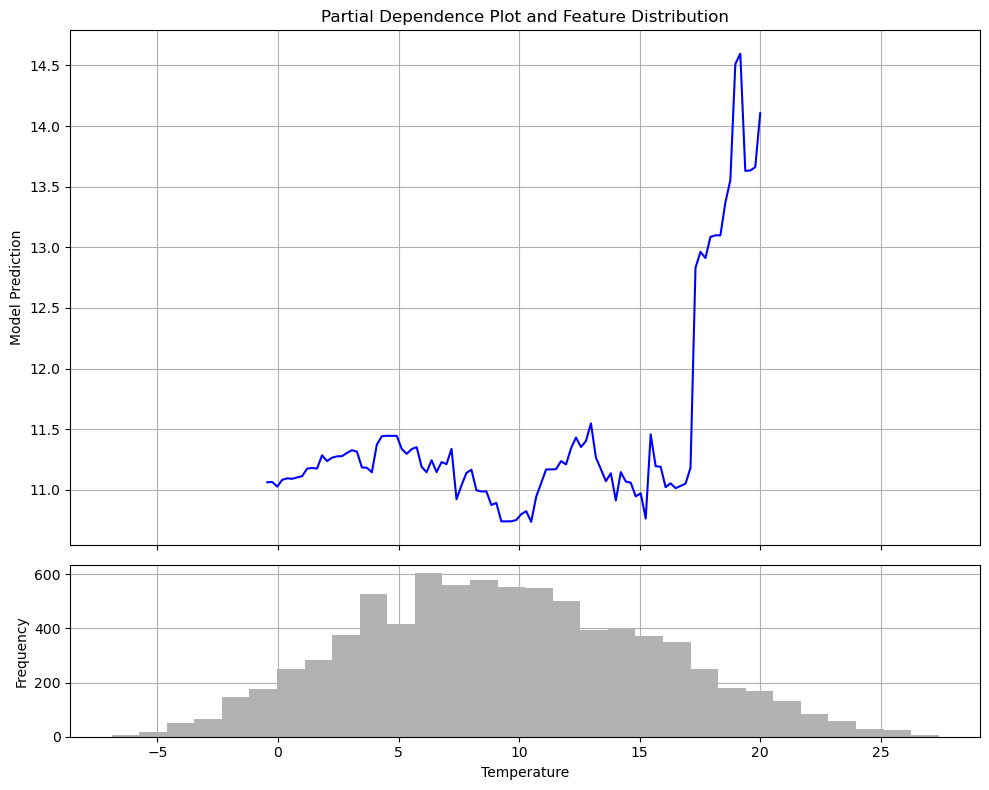

In [50]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# PDP
ax1.plot(pardep['grid_values'][0], pardep['average'][0], color='blue')
ax1.set_ylabel('Model Prediction')
ax1.set_title('Partial Dependence Plot and Feature Distribution')
ax1.grid(True)

# Histogram
ax2.hist(sample_df['temp'], bins=30, color='gray', alpha=0.6)
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Frequency')
ax2.grid(True)

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
<b> Exercise 2 - Generate partial dependency plots to understand relationships between PM2.5 predictions and meteorology.<a name="Exercise2"></a></b> 
    
Repeat the above workflow to compare ML models fit to our data but matching the following criteria:
    
    - Now include data from 2017, 2018 and 2019 to build a predictor of PM2.5.
    - Use 15 parameter settings that are sampled from the randomised hyperparameter search
    
Then produce:
 -  A joint PDF and histogram plot of temperature effects on predicted PM2.5

<div style="border-left: 5px solid #1f77b4; background-color: #f0f8ff; padding: 10px; margin: 10px 0;">
    <strong>💡 Please note:</strong> You may wish to start using exercise specific names for dataframes and outputs. For example, sample_df_ex2, best_model_ex2 and so on to avoid confusion with previously generated outputs and models.
</div>

**Do you see a significant different in the relationship between temperature on predicted PM2.5?**

</div>

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best parameters found: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}
Test R^2: 0.12767075635715341


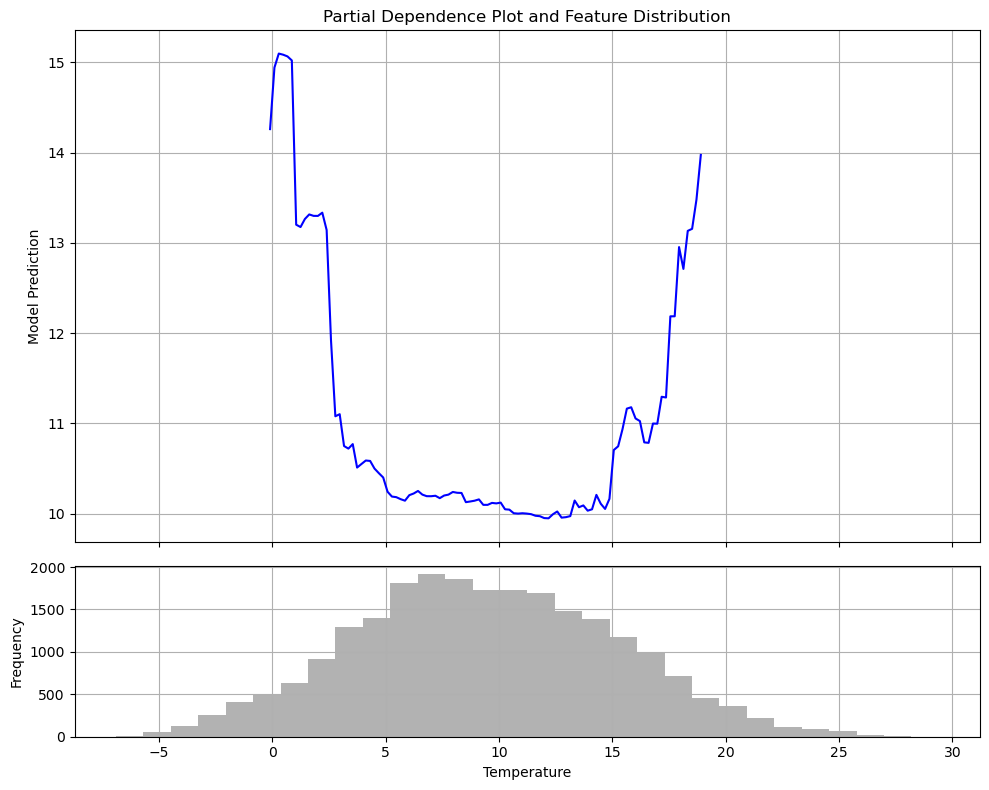

In [51]:
# ------------- INSERT CODE HERE -----------------

sample_df_ex2 = MAN3_DATA[(MAN3_DATA.index.year == 2017) | (MAN3_DATA.index.year == 2018) | (MAN3_DATA.index.year == 2019)]

y=sample_df_ex2[['PM2.5']].values
X=sample_df_ex2[['wd', 'ws', 'temp', 'AT2.5', 'AP2.5', 'u10', 'v10', 'd2m', 't2m', 'blh', 'sp', 'ssrd', 'tp', 'r', 'U', 'V','hour', 'day', 'month', 'unix', 'day_of_year']].values

# First split: 85% train+val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=10
)

# Second split: from the 85%, split 80% train, 20% val → gives 68% train, 17% val
X_train, X_validate, y_train, y_validate = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=10
)

# Define the parameter distributions to sample from
param_distributions = {
    'n_estimators':      [100, 200, 300, 400],
    'learning_rate':     [0.01, 0.05, 0.1],
    'max_depth':         [3, 5, 7, 9],
    'subsample':         [0.6, 0.8, 1.0],
    'colsample_bytree':  [0.6, 0.8, 1.0],
    'gamma':             [0, 0.1, 1, 5],
    'min_child_weight':  [1, 3, 5],
    'reg_alpha':         [0, 0.01, 0.1, 1],
    'reg_lambda':        [0.1, 1, 2, 5]
}

# Create the XGBoost regressor
xgb_reg = XGBRegressor(random_state=42)

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_distributions,
    n_iter=15,            # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error',  
    cv=3,                 # 3-fold cross validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the random search model
random_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found:", random_search.best_params_)

# Evaluate on test set
best_model_ex2 = random_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test R^2:", test_score)

pardep_ex2 = partial_dependence(best_model_ex2, sample_df_ex2[['wd', 'ws', 'temp', 'AT2.5', 'AP2.5', 'u10', 'v10', 'd2m', 't2m', 'blh', 'sp', 'ssrd', 'tp', 'r', 'U', 'V','hour', 'day', 'month', 'unix', 'day_of_year']], ['temp'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# PDP
ax1.plot(pardep_ex2['grid_values'][0], pardep_ex2['average'][0], color='blue')
ax1.set_ylabel('Model Prediction')
ax1.set_title('Partial Dependence Plot and Feature Distribution')
ax1.grid(True)

# Histogram
ax2.hist(sample_df_ex2['temp'], bins=30, color='gray', alpha=0.6)
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Frequency')
ax2.grid(True)

plt.tight_layout()
plt.show()

# ------------------------------------------------

#### 2.2 SHAP analysis

In the above text we refer to potentially more powerful analytics, including SHAP analysis. We retain the need to answer the question: Can we use the features and parameters of a trained model to understand the underlying relationships? Take the example of linear regression; Whilst the values of the learned coefficients might offer some insight these are not a great method for understanding the importance of a given feature. The scaling of the 'X' variable, for example, will impact on the value of the coefficient. The partial depedency plots above give more insight, but also we note that the distribution of values would affect confidence in areas where data is lacking.

SHAP (SHapley Additive exPlanations) analysis is a method used to explain the output of machine learning models, particularly for complex models such as deep learning and ensemble algorithms. The main goal of SHAP analysis is to provide an understandable and interpretable representation of how the features of an input instance contribute to the model's prediction.

SHAP analysis is based on the concept of Shapley values, which originated from cooperative game theory. Shapley values provide a way to fairly distribute a total value among multiple contributors, based on their individual contributions. Shapley values are a concept originating from cooperative game theory, proposed by Lloyd Shapley in 1953. They provide a method for fairly allocating the gains or costs of a cooperative game among its players, taking into account their individual contributions. The Shapley value has several desirable properties, such as efficiency, symmetry, dummy player property, and additivity.

In the context of machine learning, Shapley values are used to allocate the contribution of each feature to the model's prediction for a specific instance. The main idea is to treat the features as players in a cooperative game, where the "gain" is the difference between the prediction for the instance and the average prediction for the entire dataset.

Here's a more detailed explanation of the Shapley value calculation for a machine learning model:

 - 1. Consider all possible subsets of features, including the empty set and the set with all features. For a model with n features, there are 2^n possible subsets.
 - 2. For each subset, evaluate the model's prediction using only the features in that subset. For features not in the subset, use a reference value, such as the feature's mean or median value from the dataset.
  - 3. Calculate the marginal contribution of each feature by comparing the prediction of a subset that includes the feature with the prediction of the same subset without the feature.
  - 4. Compute the Shapley value for each feature by taking the weighted average of its marginal contributions across all possible subsets. The weight for each subset is given by the formula:
  - Weight = (|S|!(n-|S|-1)!)/(n!)

where |S| is the number of features in subset S, and n is the total number of features.
The Shapley values have some key properties that make them suitable for explaining machine learning models:

 - a) Efficiency: The sum of the Shapley values for all features equals the total gain, which is the difference between the model's prediction for the instance and the average prediction for the entire dataset.
 - b) Symmetry: If two features contribute equally to the model's prediction, they will have the same Shapley value.
 - c) Dummy player property: If a feature has no impact on the prediction, its Shapley value will be zero.
 - d) Additivity: If the gains from two different cooperative games can be combined, the Shapley values of the combined game will be the sum of the Shapley values of the individual games.

By using Shapley values, we can fairly allocate the contributions of each feature to the model's prediction and provide an interpretable explanation for complex machine learning models.

*One of the fundemental properties of Shapley values is that they always sum up to the difference between the game outcome when all players are present and the game outcome when no players are present. For machine learning models this means that SHAP values of all the input features will always sum up to the difference between baseline (expected) model output and the current model output for the prediction being explained.* 


We dont have to implement our own method to calculate Shapley values. We import the <code> shap </code> package to do this for us. We pass our previously fit model to a <code> TreeExplainer </code> function and extract shap values based on a validation dataset as per the code given below.

Notice that we have to create a training and validation split in our dataset again. We pass the validation datset to our SHAP analysis to extract the shapely values.

##### Do I Still Need Train, Validation, and Test Sets When Using SHAP?

You **can** use just **train and validation sets**, but it’s strongly recommended to keep a **separate test set** for final evaluation — especially when using SHAP for interpretability.

##### Why Keep Three Sets?

| **Split**     | **Purpose**                       | **SHAP Role**                                      |
|---------------|------------------------------------|----------------------------------------------------|
| **Train**      | Used to fit the model              | SHAP explains how the model learned from training data |
| **Validation** | Used for tuning model parameters   | SHAP helps you understand model performance while tuning |
| **Test**       | Final, unbiased evaluation         | SHAP reveals how the model generalizes to new data |


##### ✅ SHAP on the Validation Set
Use **during model development** to:
- Understand how the model is making predictions before finalizing it.
- Guide hyperparameter tuning or feature engineering.
- Identify feature influence while you're still adjusting the model.

---

##### ✅ SHAP on the Test Set
Use **after final model selection** to:
- Evaluate the model’s behavior on **completely unseen data**.
- Confirm that it generalizes well and relies on similar patterns.
- Build trust and transparency in your results for reporting or deployment.

---

##### Summary

| Stage       | Dataset       | Purpose                         |
|-------------|----------------|----------------------------------|
| Development | Validation set | Understand + improve model       |
| Final Check | Test set       | Confirm generalization + explain |

Using both sets for SHAP provides a **complete picture**: how the model behaves while you're building it, and how it performs in the real world.

So lets see this in action in the code below:


SHAP Summary Plot – Validation Set


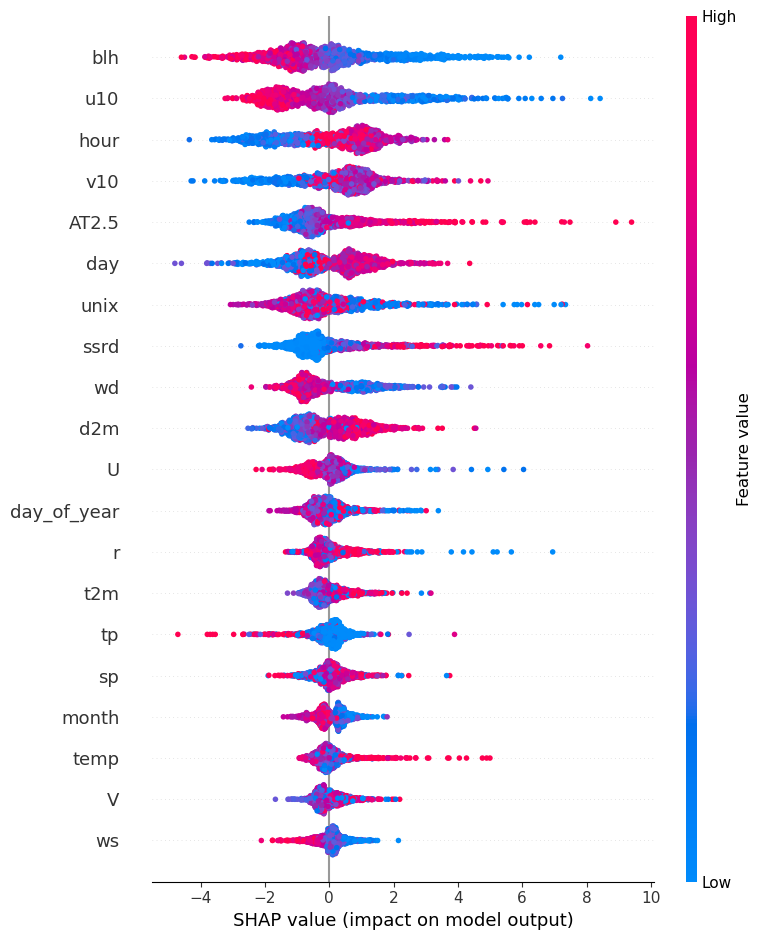

SHAP Summary Plot – Test Set


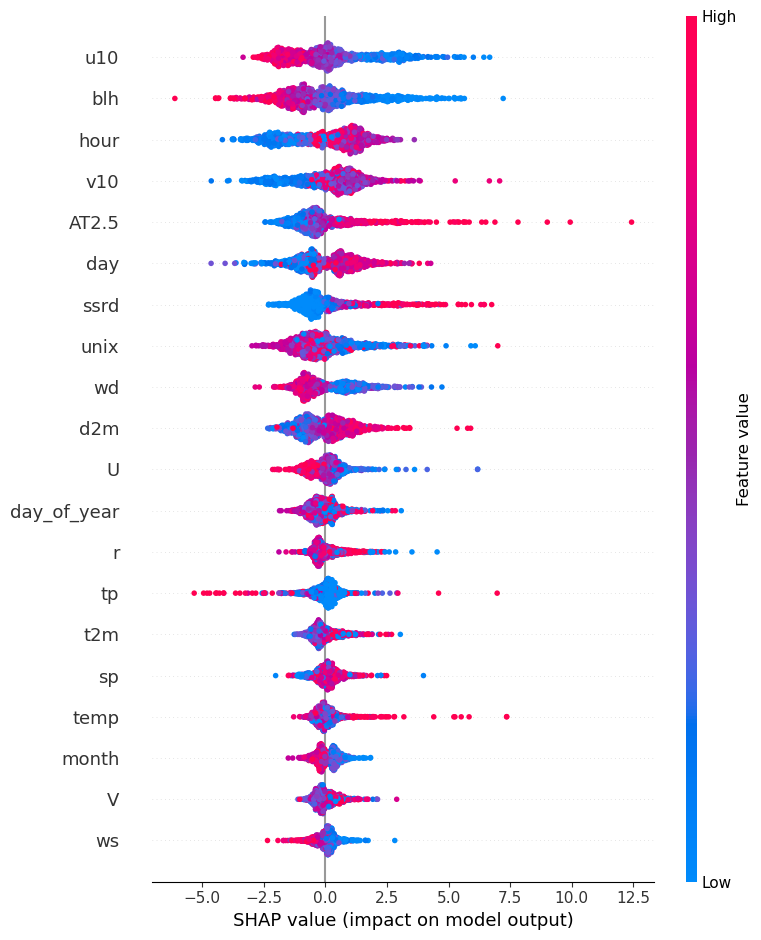

In [52]:
# create train/validation split - repeating what we had earlier just for clarity!
sample_df=MAN3_DATA[MAN3_DATA.index.year==2018]

y=sample_df[['PM2.5']].values
X=sample_df[['wd', 'ws', 'temp', 'AT2.5', 'AP2.5', 'u10', 'v10', 'd2m', 't2m', 'blh', 'sp', 'ssrd', 'tp', 'r', 'U', 'V','hour', 'day', 'month', 'unix', 'day_of_year']].values

# First split: 85% train+val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=10
)

# Second split: from the 85%, split 80% train, 20% val → gives 68% train, 17% val
X_train, X_validate, y_train, y_validate = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=10
)

# Provided this has been generated, you can now call the SHAP TreeExplainer function
explainer = shap.TreeExplainer(best_model)

# --- SHAP on the validation set ---
shap_values_val = explainer.shap_values(X_validate)

# Summary plot for validation set
print("SHAP Summary Plot – Validation Set")
shap.summary_plot(shap_values_val, X_validate, feature_names=[
    'wd', 'ws', 'temp', 'AT2.5', 'AP2.5', 'u10', 'v10', 'd2m', 't2m', 'blh', 
    'sp', 'ssrd', 'tp', 'r', 'U', 'V', 'hour', 'day', 'month', 'unix', 'day_of_year'
])

# --- SHAP on the test set ---
shap_values_test = explainer.shap_values(X_test)

# Summary plot for test set
print("SHAP Summary Plot – Test Set")
shap.summary_plot(shap_values_test, X_test, feature_names=[
    'wd', 'ws', 'temp', 'AT2.5', 'AP2.5', 'u10', 'v10', 'd2m', 't2m', 'blh', 
    'sp', 'ssrd', 'tp', 'r', 'U', 'V', 'hour', 'day', 'month', 'unix', 'day_of_year'
])


The SHAP summary plot gives a **global view** of how each feature in your model affects its predictions — both in terms of **importance** and **direction**.

- **Y-Axis**: Features, sorted by importance (top = most influential).
- **X-Axis**: SHAP values (impact on the model’s prediction).
  - Values to the **right**: the feature increases the prediction.
  - Values to the **left**: the feature decreases the prediction.
- **Color**: The actual value of the feature for each sample.
  - **Red** = high value of the feature.
  - **Blue** = low value of the feature.

Each point is one prediction (i.e., one row in your dataset).

We can also use the internal depedency plot of the SHAP package to visualise the dependency on our regressed variable [in this case PM2.5], on any features. In the plot below, we can visualise the joint dependency on temperature and RH. Notice how, in this function call, we pass the value of <code> interaction_index </code>. In this case we set this to 'r', the name of the column that represents relative humidity.

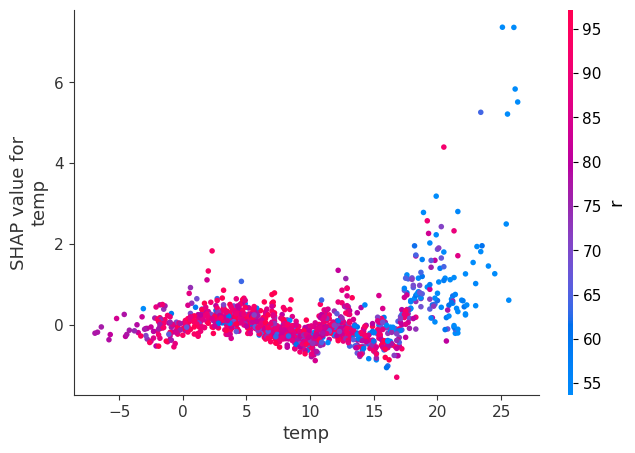

In [54]:
shap.dependence_plot("temp", shap_values_test, X_test, interaction_index="r", feature_names=[
    'wd', 'ws', 'temp', 'AT2.5', 'AP2.5', 'u10', 'v10', 'd2m', 't2m', 'blh', 
    'sp', 'ssrd', 'tp', 'r', 'U', 'V', 'hour', 'day', 'month', 'unix', 'day_of_year'
])


So we can see here that we still infer that predicted PM2.5 increases at highest temperatures for our dataset restricted to 2018. But we also see that those higher temperatures correspond to lower relative humidity, whilst the lower temperatures higher humidity. Does this make sense?

Passing a matrix of SHAP values to the bar plot function creates a global feature importance plot, where the global importance of each feature is taken to be the mean absolute value for that feature over all the given samples.

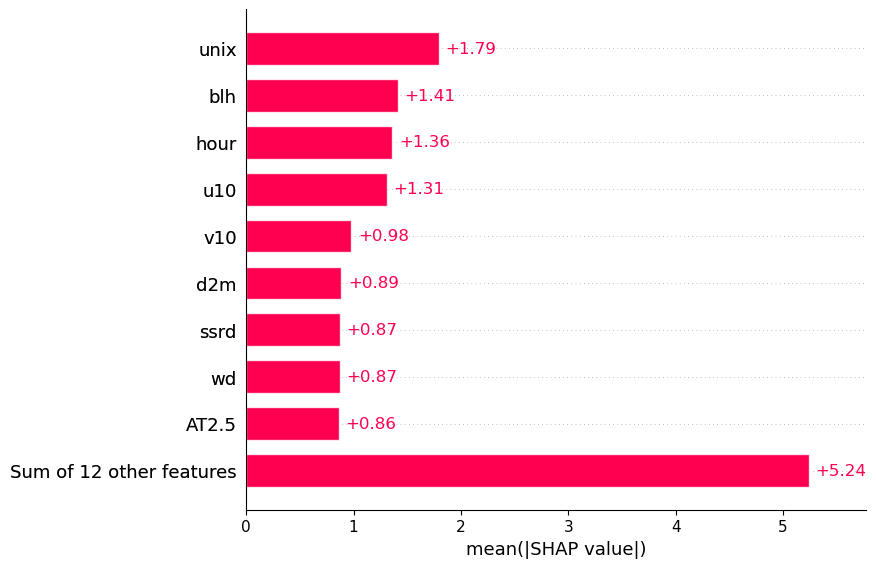

In [56]:
# Provided this has been generated, you can now call the SHAP TreeExplainer function
explainer = shap.TreeExplainer(best_model)

shap_values = explainer(X_test)
shap_values.feature_names = ['wd', 'ws', 'temp', 'AT2.5', 'AP2.5', 'u10', 'v10', 'd2m', 't2m', 'blh', 'sp', 'ssrd', 'tp', 'r', 'U', 'V','hour', 'day', 'month', 'unix', 'day_of_year']
shap.plots.bar(shap_values)

<div class="alert alert-block alert-success">
<b> Exercise 3 - Generate SHAP analysis for predicting PM2.5 at Manchester Piccadilly site.<a name="Exercise3"></a></b> 
    
Repeat the above workflow to compare ML models fit to our data but matching the following criteria:
    
    - Now include data from 2017, 2018 and 2019 to build a predictor of PM2.5.
    - Use 15 parameter settings that are sampled from the randomised hyperparameter search
    
Then produce:
 -  A SHAP summary plot
 -  A SHAP dependence plott to visualise the joint dependency on temperature and RH.

<div style="border-left: 5px solid #1f77b4; background-color: #f0f8ff; padding: 10px; margin: 10px 0;">
    <strong>💡 Please note:</strong> You may wish to start using exercise specific names for dataframes and outputs. For example, sample_df_ex3, best_model_ex3 and so on to avoid confusion with previously generated outputs and models.
</div>

**Do you see a significant different in the relationship between temperature on predicted PM2.5?**

</div>

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best parameters found: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}
Test R^2: 0.12767075635715341
SHAP Summary Plot – Test Set


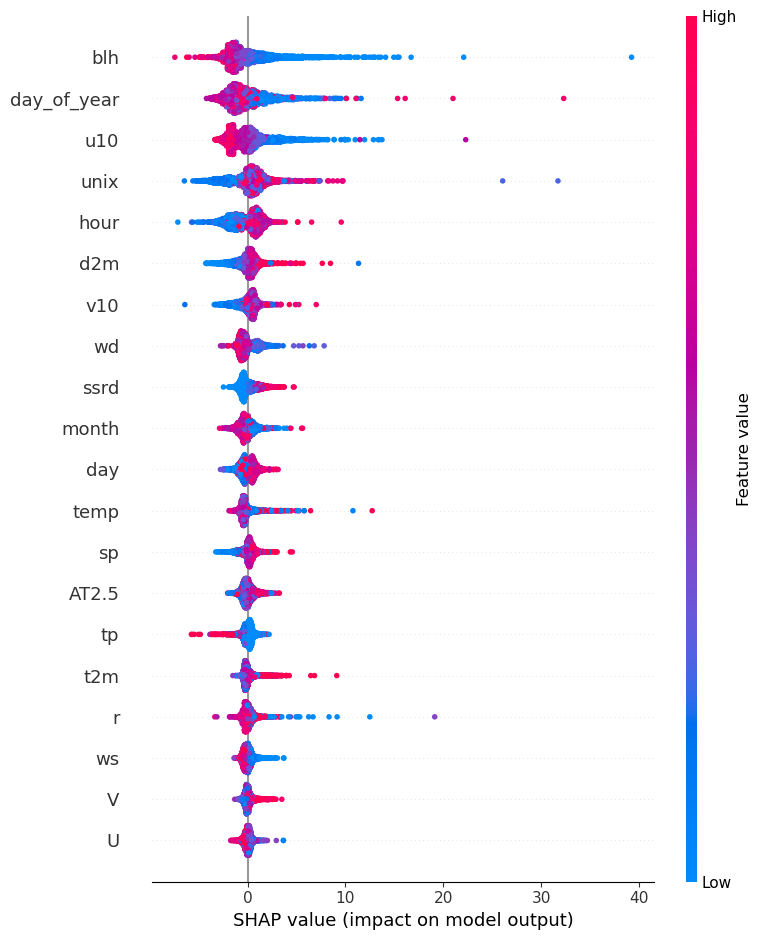

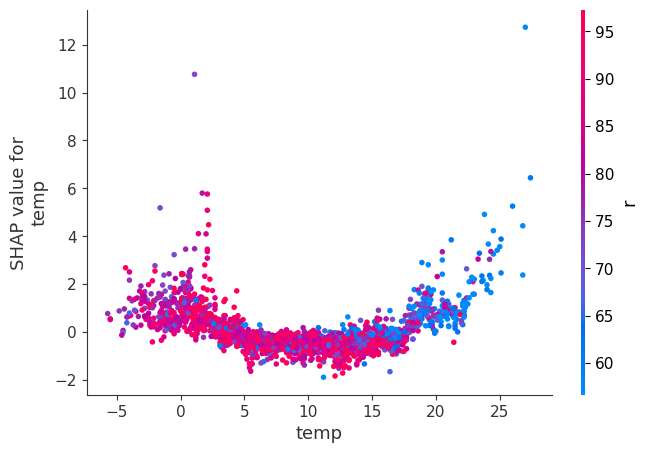

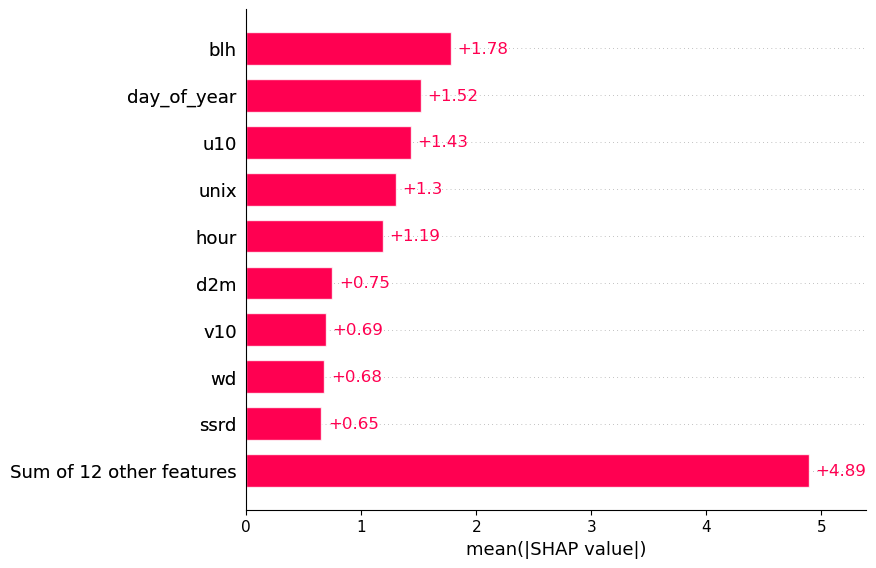

In [59]:
# ------------- INSERT CODE HERE -----------------

sample_df_ex3 = MAN3_DATA[(MAN3_DATA.index.year == 2017) | (MAN3_DATA.index.year == 2018) | (MAN3_DATA.index.year == 2019)]

y=sample_df_ex3[['PM2.5']].values
X=sample_df_ex3[['wd', 'ws', 'temp', 'AT2.5', 'AP2.5', 'u10', 'v10', 'd2m', 't2m', 'blh', 'sp', 'ssrd', 'tp', 'r', 'U', 'V','hour', 'day', 'month', 'unix', 'day_of_year']].values

# First split: 85% train+val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=10
)

# Second split: from the 85%, split 80% train, 20% val → gives 68% train, 17% val
X_train, X_validate, y_train, y_validate = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=10
)

# Define the parameter distributions to sample from
param_distributions = {
    'n_estimators':      [100, 200, 300, 400],
    'learning_rate':     [0.01, 0.05, 0.1],
    'max_depth':         [3, 5, 7, 9],
    'subsample':         [0.6, 0.8, 1.0],
    'colsample_bytree':  [0.6, 0.8, 1.0],
    'gamma':             [0, 0.1, 1, 5],
    'min_child_weight':  [1, 3, 5],
    'reg_alpha':         [0, 0.01, 0.1, 1],
    'reg_lambda':        [0.1, 1, 2, 5]
}

# Create the XGBoost regressor
xgb_reg = XGBRegressor(random_state=42)

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_distributions,
    n_iter=15,            # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error',  
    cv=3,                 # 3-fold cross validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the random search model
random_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found:", random_search.best_params_)

# Evaluate on test set
best_model_ex3 = random_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test R^2:", test_score)

# Provided this has been generated, you can now call the SHAP TreeExplainer function
explainer = shap.TreeExplainer(best_model_ex3)

# --- SHAP on the test set ---
shap_values_test = explainer.shap_values(X_test)

# Summary plot for test set
print("SHAP Summary Plot – Test Set")
shap.summary_plot(shap_values_test, X_test, feature_names=[
    'wd', 'ws', 'temp', 'AT2.5', 'AP2.5', 'u10', 'v10', 'd2m', 't2m', 'blh', 
    'sp', 'ssrd', 'tp', 'r', 'U', 'V', 'hour', 'day', 'month', 'unix', 'day_of_year'
])

shap.dependence_plot("temp", shap_values_test, X_test, interaction_index="r", feature_names=[
    'wd', 'ws', 'temp', 'AT2.5', 'AP2.5', 'u10', 'v10', 'd2m', 't2m', 'blh', 
    'sp', 'ssrd', 'tp', 'r', 'U', 'V', 'hour', 'day', 'month', 'unix', 'day_of_year'
])

shap_values = explainer(X_test)
shap_values.feature_names = ['wd', 'ws', 'temp', 'AT2.5', 'AP2.5', 'u10', 'v10', 'd2m', 't2m', 'blh', 'sp', 'ssrd', 'tp', 'r', 'U', 'V','hour', 'day', 'month', 'unix', 'day_of_year']
shap.plots.bar(shap_values)
# ------------------------------------------------



# 3) Automated machine learning models of pollutant concentrations

AutoML (Automated Machine Learning) is a framework or set of tools designed to automate the process of building and optimizing machine learning models. Instead of manually experimenting with numerous algorithms, hyperparameter values, and preprocessing steps, AutoML systems systematically explore these options on behalf of the user. For scientists, this is particularly beneficial because it lowers the barrier to entry for using ML techniques, saves time by bypassing repetitive tuning tasks, and accelerates model development through rapid experimentation. As a result, researchers can spend more effort focusing on interpreting results and extracting scientific insights, rather than the mechanics of model building.

FLAML (Fast and Lightweight AutoML,https://microsoft.github.io/FLAML/docs/getting-started) is an open-source, lightweight, and efficient automatic machine learning (AutoML) library designed to simplify the machine learning process. Developed by Microsoft, FLAML aims to make AutoML more accessible by providing fast and cost-effective solutions for model training and hyperparameter tuning without compromising accuracy.

Unlike many other AutoML frameworks, FLAML focuses on simplicity and speed by employing lightweight model selection strategies and dynamic resource allocation, which makes it well-suited for large datasets or scenarios with limited computational budgets. Out of the box, FLAML supports several popular model families, including:

 - LightGBM (gradient boosting trees)
 - XGBoost (gradient boosting trees)
 - Random Forest (via scikit-learn)
 - Extra Trees (via scikit-learn)
 - Linear Models (e.g., Lasso, Ridge, ElasticNet via scikit-learn)
   
##### What You *Don't* Need to Do When Using FLAML

FLAML is designed to make model selection and hyperparameter tuning easy and efficient. Here’s what you **don’t** need to worry about:

##### You don’t need to define hyperparameter grids
FLAML automatically searches for the best hyperparameters using an efficient, cost-aware tuning method — no need to manually specify ranges like with `RandomizedSearchCV` or `GridSearchCV`.

##### You don’t need to choose specific models (learners) [but we will]
By default, FLAML tries a variety of model types and automatically selects the best one based on your metric:
- LightGBM (`lgbm`)
- XGBoost (`xgboost`)
- Random Forest (`rf`)
- Lasso (`lasso`)
- ExtraTrees (`extra_tree`)
- CatBoost (`catboost`) *(if installed)*

You only need to limit the model list if you have a specific reason.

##### You don’t need to manually tune or set scoring metrics
Just set `"metric": "r2"` (or `"mae"`, `"mse"`, etc.) in the settings — FLAML takes care of the rest.


This makes FLAML especially helpful when you want strong performance **without having to micromanage hyperparameters or model selection**. In the following code we set a few initial options, including setting a time limit for the model fitting:


In [63]:
from flaml import AutoML

# set the parameters for AutoML
automl = AutoML()
automl_settings = {
            "time_budget": 20,
            "metric": 'r2',
            "task": 'regression',
            "estimator_list": ["lgbm", "rf", "xgboost", "extra_tree"],
            'seed': 7654321
        }

Now we can simply fit and search for the best model using the following code. **Please recall that we are fitting to X_train and y_train, so you need to be careful what scenarios these represent. Im repeating the process below for 3 selected years just for clarity.**

In [64]:
sample_df_ex3 = MAN3_DATA[(MAN3_DATA.index.year == 2017) | (MAN3_DATA.index.year == 2018) | (MAN3_DATA.index.year == 2019)]

y=sample_df_ex3[['PM2.5']].values
X=sample_df_ex3[['wd', 'ws', 'temp', 'AT2.5', 'AP2.5', 'u10', 'v10', 'd2m', 't2m', 'blh', 'sp', 'ssrd', 'tp', 'r', 'U', 'V','hour', 'day', 'month', 'unix', 'day_of_year']].values

# First split: 85% train+val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=10
)

# Second split: from the 85%, split 80% train, 20% val → gives 68% train, 17% val
X_train, X_validate, y_train, y_validate = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=10
)

# run the AutoML
automl.fit(X_train=X_train, y_train=y_train, X_val=X_validate, y_val=y_validate, **automl_settings)

[flaml.automl.logger: 05-27 18:14:30] {1728} INFO - task = regression
[flaml.automl.logger: 05-27 18:14:30] {1736} INFO - Data split method: uniform
[flaml.automl.logger: 05-27 18:14:30] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 05-27 18:14:30] {1838} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 05-27 18:14:30] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree']
[flaml.automl.logger: 05-27 18:14:30] {2258} INFO - iteration 0, current learner lgbm


TypeError: 'NoneType' object is not callable